# Imports

In [1]:
import numpy as np
import scipy as sp
import scipy.optimize
import matplotlib.pyplot as plt

# Import data

https://www.cset-foretell.com/questions/93-what-will-the-dollar-value-of-u-s-exports-of-semiconductor-chips-to-china-be-in-the-first-half-of-2021

In [2]:
# Data from https://docs.google.com/spreadsheets/d/1EcDCcmAZEBtAinKiihbJTQyUUHcSvCJ9Qtqb55TCKDY/edit#gid=692543022
data = {"date": np.array([2014.0, 2014.5, 2015.0, 2015.5, 2016.0, 2016.5, 2017.0, 2017.5, 
                          2018.0, 2018.5, 2019.0, 2019.5, 2020.0]) - 2014,
       "quant": np.array([2008178186, 2467481307, 2346783148, 2659330499, 2414793804, 2764693603, 
                          2408053469, 2878326021, 2690440177, 3406625601, 4134127600, 4015046435, 4880404188]) * 1e-9}

xlabel = 'Time [years since 2014]'
ylabel = 'Value of chip exports [bn $]'

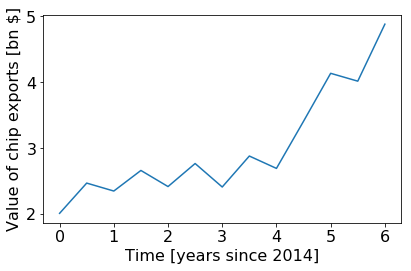

In [3]:
plt.rcParams.update({'font.size': 16})
fig, ax = plt.subplots(1,1)

ax.plot(data['date'], data['quant'])
ax.set_xlabel(xlabel)
ax.set_ylabel(ylabel)

plt.tight_layout()

# Generate trend-fit values, linear

In [4]:
def outside_func(t, m, b):
    return m*t + b

In [5]:
slope_guess = 1 # 1 bn $ / year
offs_guess = 2
popt, pcov = sp.optimize.curve_fit(outside_func, data['date'], data['quant'], p0=[slope_guess, offs_guess])
perr = np.sqrt(np.diag(pcov)) # The standard deviations of the parameters

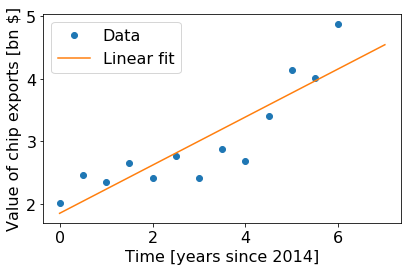

In [6]:
fig, ax = plt.subplots(1,1)

t_final = 7
fit_label = 'Linear fit'
ax.plot(data['date'], data['quant'], 'o', label='Data')
t_plot = np.linspace(0, t_final, 100)
ax.plot(t_plot, outside_func(t_plot, *popt), label=fit_label)
ax.set_xlabel(xlabel)
ax.set_ylabel(ylabel)

ax.legend()

plt.tight_layout()

In [7]:
outside_func(t_final, *popt)

4.545378769067208

## Monte Carlo of trends

I think with the fit we could probably just build up the probability density function P(y) =  Pr(f(x) = y) for the ranges of y we care about, just given our fit parameters and covariance matrix. However, I think an equivalent way to do this is to just run a monte carlo simulation were we randomly sample from our fit parameters, drawing the fit parameters form the multivariate gaussian distribution defined by popt and pcov. Then bin the value of f(x) that we get from the simulation.

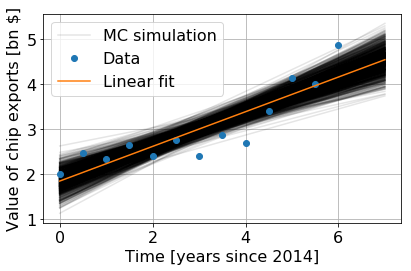

In [8]:
# Generate fits

n_fits = 1000
fit_params_gen = np.random.multivariate_normal(popt, pcov, n_fits)


fit_params = fit_params_gen
# Comment out the line above and uncomment the below lines to clean to fit based on some criteria. 
# Be very careful throwing only a lot of data though!!
# fit_params = []
# n_removed = 0
# for fit_list in fit_params_gen:
#     if fit_list[0] < 0:
#         n_removed += 1
#         n_fits -= 1
#     else:
#         fit_params.append(fit_list)
# print('Generated %i plots, discarded %i' %(n_fits + n_removed, n_removed))


# Plot MC simualtions and build MC data
fig, ax_mc = plt.subplots(1,1)

final_vals = []
for i, popt_mc in enumerate(fit_params):
    label = 'MC simulation' if i == 0 else None 
    t_plot = np.linspace(0, t_final, 100)
    ax_mc.plot(t_plot, outside_func(t_plot, *popt_mc), 'k', alpha=0.1, label=label)
    
    final_vals.append(outside_func(np.array([t_final]), *popt_mc)[0])
    
# Plot original data and fit
ax_mc.plot(data['date'], data['quant'], 'o', label='Data')
t_plot = np.linspace(0, t_final, 100)
ax_mc.plot(t_plot, outside_func(t_plot, *popt), label=fit_label)

ax_mc.set_xlabel(xlabel)
ax_mc.set_ylabel(ylabel)

ax_mc.grid()
ax_mc.legend()

plt.tight_layout()

## Including histogram

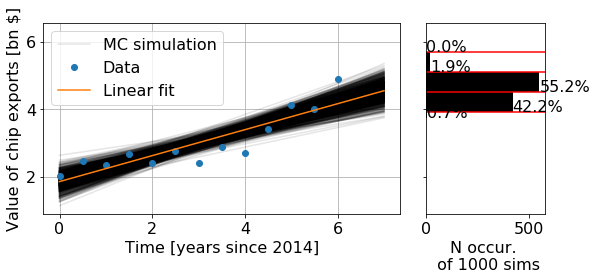

In [9]:
# Plot MC simualtions and build MC data
cset_boundaries = [3.9, 4.5, 5.1, 5.7]

fig, [ax_mc, ax_hist] = plt.subplots(1, 2, figsize=(8, 4), gridspec_kw={'width_ratios': [3, 1]}, sharey=True)

for i, popt_mc in enumerate(fit_params):
    label = 'MC simulation' if i == 0 else None 
    t_plot = np.linspace(0, t_final, 100)
    ax_mc.plot(t_plot, outside_func(t_plot, *popt_mc), 'k', alpha=0.1, label=label)
        
# Plot original data and fit
ax_mc.plot(data['date'], data['quant'], 'o', label='Data')
t_plot = np.linspace(0, t_final, 100)
ax_mc.plot(t_plot, outside_func(t_plot, *popt), label=fit_label)

# for boundary in cset_boundaries:
#     ax_mc.axhline(boundary, color='r', linewidth=0.3)

ax_mc.set_xlabel(xlabel)
ax_mc.set_ylabel(ylabel)
# ax_mc.set_yscale('log')

ax_mc.grid()
ax_mc.legend()




# Plot histogram
bin_min = min(final_vals) if min(final_vals) < min(cset_boundaries) else min(cset_boundaries) - np.diff(cset_boundaries)[0]
bin_max = max(final_vals) if max(final_vals) > max(cset_boundaries) else max(cset_boundaries) + np.diff(cset_boundaries)[-1]

bins = np.concatenate([[bin_min], cset_boundaries, [bin_max]])

n, bins, patches = ax_hist.hist(np.array(final_vals), bins, color='k', orientation='horizontal')
# ax_hist.set_ylim(ax_mc.get_ylim())

ax_hist.set_xlabel('N occur. \n of {} sims'.format(n_fits))

for boundary in cset_boundaries:
    ax_hist.axhline(boundary, color='r')
    
text_offset = (max(bins) - min(bins)) / 100
percentages = [n_val / n_fits * 100 for n_val in n]
for n_val, bin_min, percent in zip(n, bins[:-1], percentages):
    ax_hist.text(n_val, bin_min + text_offset, '%.1f%%' %(percent))


plt.tight_layout()

In [10]:
percentages_linear = percentages
final_vals_linear = final_vals

# Generate trend-fit values, exponential fit

In [11]:
def outside_func(t, a, tau, b):
    return a*np.exp(t/tau) + b

In [12]:
a_guess = 1
tau_guess = 10
offs_guess = 2
popt, pcov = sp.optimize.curve_fit(outside_func, data['date'], data['quant'], p0=[a_guess, tau_guess, offs_guess])
perr = np.sqrt(np.diag(pcov)) # The standard deviations of the parameters

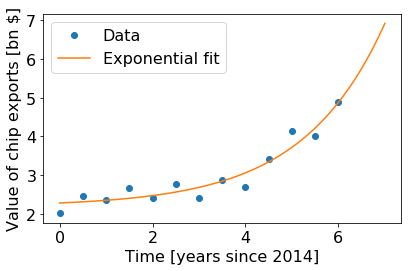

In [13]:
fig, ax = plt.subplots(1,1)

t_final = 7
fit_label = 'Exponential fit'
ax.plot(data['date'], data['quant'], 'o', label='Data')
t_plot = np.linspace(0, t_final, 100)
ax.plot(t_plot, outside_func(t_plot, *popt), label=fit_label)
ax.set_xlabel(xlabel)
ax.set_ylabel(ylabel)

ax.legend()

plt.tight_layout()

In [14]:
outside_func(t_final, *popt)

6.92440868359785

In [15]:
popt

array([0.09081673, 1.77000204, 2.18512504])

## Monte Carlo of trends

I think with the fit we could probably just build up the probability density function P(y) =  Pr(f(x) = y) for the ranges of y we care about, just given our fit parameters and covariance matrix. However, I think an equivalent way to do this is to just run a monte carlo simulation were we randomly sample from our fit parameters, drawing the fit parameters form the multivariate gaussian distribution defined by popt and pcov. Then bin the value of f(x) that we get from the simulation.

Generated 1000 plots, discarded 117


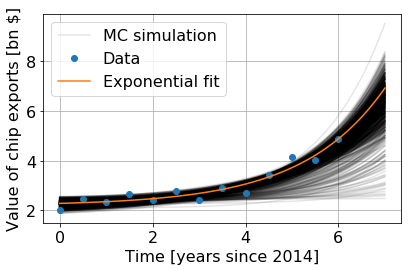

In [16]:
# Generate fits

n_fits = 1000
fit_params_gen = np.random.multivariate_normal(popt, pcov, n_fits)


# fit_params = fit_params_gen
# Comment out the line above and uncomment the below lines to clean to fit based on some criteria. 
# Be very careful throwing only a lot of data though!!
fit_params = []
n_removed = 0
for fit_list in fit_params_gen:
    if fit_list[0] < 0:
        n_removed += 1
        n_fits -= 1
    else:
        fit_params.append(fit_list)
print('Generated %i plots, discarded %i' %(n_fits + n_removed, n_removed))


# Plot MC simualtions and build MC data
fig, ax_mc = plt.subplots(1,1)

final_vals = []
for i, popt_mc in enumerate(fit_params):
    label = 'MC simulation' if i == 0 else None 
    t_plot = np.linspace(0, t_final, 100)
    ax_mc.plot(t_plot, outside_func(t_plot, *popt_mc), 'k', alpha=0.1, label=label)
    
    final_vals.append(outside_func(np.array([t_final]), *popt_mc)[0])
    
# Plot original data and fit
ax_mc.plot(data['date'], data['quant'], 'o', label='Data')
t_plot = np.linspace(0, t_final, 100)
ax_mc.plot(t_plot, outside_func(t_plot, *popt), label=fit_label)

ax_mc.set_xlabel(xlabel)
ax_mc.set_ylabel(ylabel)

ax_mc.grid()
ax_mc.legend()

plt.tight_layout()

## Including histogram

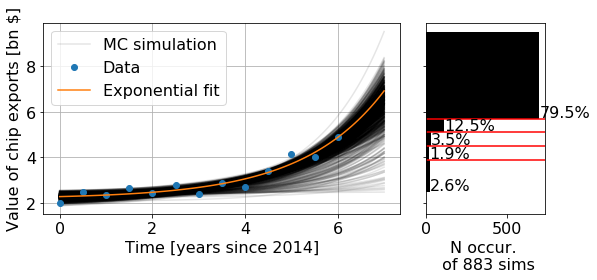

In [17]:
# Plot MC simualtions and build MC data
cset_boundaries = [3.9, 4.5, 5.1, 5.7]

fig, [ax_mc, ax_hist] = plt.subplots(1, 2, figsize=(8, 4), gridspec_kw={'width_ratios': [3, 1]}, sharey=True)

for i, popt_mc in enumerate(fit_params):
    label = 'MC simulation' if i == 0 else None 
    t_plot = np.linspace(0, t_final, 100)
    ax_mc.plot(t_plot, outside_func(t_plot, *popt_mc), 'k', alpha=0.1, label=label)
        
# Plot original data and fit
ax_mc.plot(data['date'], data['quant'], 'o', label='Data')
t_plot = np.linspace(0, t_final, 100)
ax_mc.plot(t_plot, outside_func(t_plot, *popt), label=fit_label)

# for boundary in cset_boundaries:
#     ax_mc.axhline(boundary, color='r', linewidth=0.3)

ax_mc.set_xlabel(xlabel)
ax_mc.set_ylabel(ylabel)
# ax_mc.set_yscale('log')

ax_mc.grid()
ax_mc.legend()




# Plot histogram
bin_min = min(final_vals) if min(final_vals) < min(cset_boundaries) else min(cset_boundaries) - np.diff(cset_boundaries)[0]
bin_max = max(final_vals) if max(final_vals) > max(cset_boundaries) else max(cset_boundaries) + np.diff(cset_boundaries)[-1]

bins = np.concatenate([[bin_min], cset_boundaries, [bin_max]])

n, bins, patches = ax_hist.hist(np.array(final_vals), bins, color='k', orientation='horizontal')
# ax_hist.set_ylim(ax_mc.get_ylim())

ax_hist.set_xlabel('N occur. \n of {} sims'.format(n_fits))

for boundary in cset_boundaries:
    ax_hist.axhline(boundary, color='r')
    
text_offset = (max(bins) - min(bins)) / 100
percentages = [n_val / n_fits * 100 for n_val in n]
for n_val, bin_min, percent in zip(n, bins[:-1], percentages):
    ax_hist.text(n_val, bin_min + text_offset, '%.1f%%' %(percent))


plt.tight_layout()

In [18]:
percentages_exponential = percentages
final_vals_exp = final_vals

# Generate final forcast

Before I saw any data, I would have put equal confidence in each of the 5 bins, so my prior was {0.2, 0.2, 0.2, 0.2, 0.2}.

I then tried to incorporate information about historical trends alone by doing both a linear fit on the data, and estimating the distribution for 2021 given the uncertainty in this linear fit. From this curve fitting, my best estimate of the probabilities of the trend reaching the values {<3.9, 3.9-4.5, 4.5-5.1, 5.1-5.7, >5.7} is {0.6%, 43.5%, 53.9%, 2%, 0%} for the linear fit and {1.7, 1.8, 3.0, 10.3, 83.2} for the exponential fit (For how I arrived at these, see https://github.com/cphenicie/forecasts/tree/main/Foretell in the file 20201111_value-of-US-chip-exports-to-China). 

I arbitrarily assigned 33% confidence to my prior values and 33% confidence to each of these trend-fits values. I then arrived at updated values by taking the mean of the prior with the trend-fit value (0.33 * [prior] + (0.33) * [linear trend-fit value] + (0.33) * [exponential trend-fit value]), and then normalizing the resulting distribution

In the future, I will try to update these priors as I learn more about the specifics of this case

In [19]:
prior = [0.2, 0.2, 0.2, 0.2, 0.2]
fit_lin = [p/100 for p in percentages_linear]
fit_exp = [p/100 for p in percentages_exponential]
mean_vals = [(0.33) * p + 0.33 * f_l + 0.33 * f_e for p, f_l, f_e in zip(prior, fit_lin, fit_exp)]
final_dist = mean_vals / np.sum(mean_vals)
print('Prior = ', prior)
print('Fit values = ', fit_lin)
print('Final distribution = ', final_dist)

Prior =  [0.2, 0.2, 0.2, 0.2, 0.2]
Fit values =  [0.007000000000000001, 0.42199999999999993, 0.552, 0.019, 0.0]
Final distribution =  [0.07768252 0.21375085 0.2623692  0.1145251  0.33167233]


# Updates based on specifics

## 2021-01-02

Read the following articles:

- https://www.scmp.com/tech/policy/article/3113606/chinas-chip-dreams-face-reality-check-bidens-united-front-approach-and
- https://www.scmp.com/news/china/diplomacy/article/3114689/under-joe-biden-tapping-us-capital-markets-will-get-even

Which I got the impression are from a source is maybe biased towards promoting Chinese soft power. They made it seem that the Biden administration will continue the Trump decoupling policies, which I think would lead to lower SME exports to China

This source says similar things (at least for the near term, I think), but is maybe biased towards a pro US-China coupling stance
- https://semiwiki.com/china/293841-the-semiconductor-industry-has-high-hopes-that-biden-will-change-tracks/

So, this updates me to think that, in this specific situation, there will generally be a decrease in US exports to China. I will need to do more digging to put a real number on this, but for now I have just shifted the probability mass of the predicted distribution from historical trends down by 3% (chosen arbitrarily, seems like a reasonable order of magnitude estimate, though)

In [35]:
update = 0.97

# Plot MC simualtions and build MC data
cset_boundaries = [3.9, 4.5, 5.1, 5.7]

bin_min = min(final_vals) * update if min(final_vals) * update < min(cset_boundaries) else min(cset_boundaries) - np.diff(cset_boundaries)[0]
bin_max = max(final_vals) * update if max(final_vals) * update > max(cset_boundaries) else max(cset_boundaries) + np.diff(cset_boundaries)[-1]

bins = np.concatenate([[bin_min], cset_boundaries, [bin_max]])

# Linear sims
n, bins = np.histogram(np.array(final_vals_linear) * update, bins)
percentages_linear = n / len(final_vals_linear) * 100

# Exp sims
n, bins = np.histogram(np.array(final_vals_exp) * update, bins)
percentages_exp = n / len(final_vals_exp) * 100

In [36]:
prior = [0.2, 0.2, 0.2, 0.2, 0.2]
fit_lin = [p/100 for p in percentages_linear]
fit_exp = [p/100 for p in percentages_exp]
mean_vals = [(0.33) * p + 0.33 * f_l + 0.33 * f_e for p, f_l, f_e in zip(prior, fit_lin, fit_exp)]
final_dist = mean_vals / np.sum(mean_vals)
print('Prior = ', prior)
print('Fit values = ', fit_lin)
print('Final distribution = ', final_dist)

Prior =  [0.2, 0.2, 0.2, 0.2, 0.2]
Fit values =  [0.024, 0.621, 0.353, 0.002, 0.0]
Final distribution =  [0.08523669 0.27932918 0.20320838 0.11829596 0.31392978]
